Imports Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set_context("notebook")


Load & Merge Enrolment CSV Files

In [2]:
file_1 = "api_data_aadhar_enrolment_0_500000.csv"
file_2 = "api_data_aadhar_enrolment_500000_1000000.csv"
file_3 = "api_data_aadhar_enrolment_1000000_1006029.csv"

df1 = pd.read_csv(file_1)
df2 = pd.read_csv(file_2)
df3 = pd.read_csv(file_3)

# Merge all enrolment data into a single DataFrame
df = pd.concat([df1, df2, df3], ignore_index=True)


In [3]:
df.shape, df.columns


((189671, 7),
 Index(['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17',
        'age_18_greater'],
       dtype='object'))

Robust Date Parsing & Essential Cleaning

In [4]:
# Robust date parsing (handles mixed formats safely)
df['date'] = pd.to_datetime(
    df['date'],
    format='mixed',
    dayfirst=True,
    errors='coerce'
)

# Drop rows with critical missing fields
df = df.dropna(subset=['date', 'state', 'district', 'pincode'])

State Name Normalization

In [5]:
import re

# Function to standardize state names
def clean_state(x):
    x = str(x).lower()
    x = re.sub(r'[^a-z\s]', ' ', x)
    x = re.sub(r'\s+', ' ', x).strip()
    return x

# Apply cleaning
df['state_clean'] = df['state'].apply(clean_state)

# Fix common known variations
state_map = {
    # Legacy / alternate spellings
    'orissa': 'Odisha',
    'pondicherry': 'Puducherry',
    'uttaranchal': 'Uttarakhand',
    'tamilnadu': 'Tamil Nadu',

    # West Bengal variants (important)
    'west bengli': 'West Bengal',
    'west bangal': 'West Bengal',
    'westbengal': 'West Bengal',
    'west bengal': 'West Bengal'
}


df['state_clean'] = df['state_clean'].replace(state_map)
df['state_clean'] = df['state_clean'].str.title()


Feature Engineering

In [6]:
# Total Aadhaar enrolments per record
df['total_enrolments'] = (
    df['age_0_5'] +
    df['age_5_17'] +
    df['age_18_greater']
)

# Ratio of adults enrolling late into Aadhaar
df['adult_late_ratio'] = (
    df['age_18_greater'] / df['total_enrolments']
)

# Ratio of child & school-age enrolments
df['child_ratio'] = (
    df['age_0_5'] + df['age_5_17']
) / df['total_enrolments']


State-Level Adult Late Enrolment Analysis/ Late-Life Aadhaar Inclusion Patterns

In [7]:
# Aggregate enrolment behaviour at the state level
state_summary = (
    df.groupby('state_clean')
      .agg(
          total_enrolments=('total_enrolments', 'sum'),
          avg_adult_late_ratio=('adult_late_ratio', 'mean')
      )
      .sort_values('avg_adult_late_ratio', ascending=False)
)

state_summary.head()


,total_enrolments,avg_adult_late_ratio
state_clean,,
,4.0,1.000000
Meghalaya,92120.0,0.275815
Mizoram,2953.0,0.099047
Dadra And Nagar Haveli And Daman And Diu,22.0,0.093750
Goa,449.0,0.087878


In [8]:
# Export key enrolment metrics for cross-dataset analysis

enrolment_export = state_summary.reset_index()[[
    'state_clean',
    'avg_adult_late_ratio'
]]

enrolment_export.to_csv(
    "enrolment_state_metrics.csv",
    index=False
)

enrolment_export.head()


,state_clean,avg_adult_late_ratio
0,,1.000000
1,Meghalaya,0.275815
2,Mizoram,0.099047
3,Dadra And Nagar Haveli And Daman And Diu,0.093750
4,Goa,0.087878


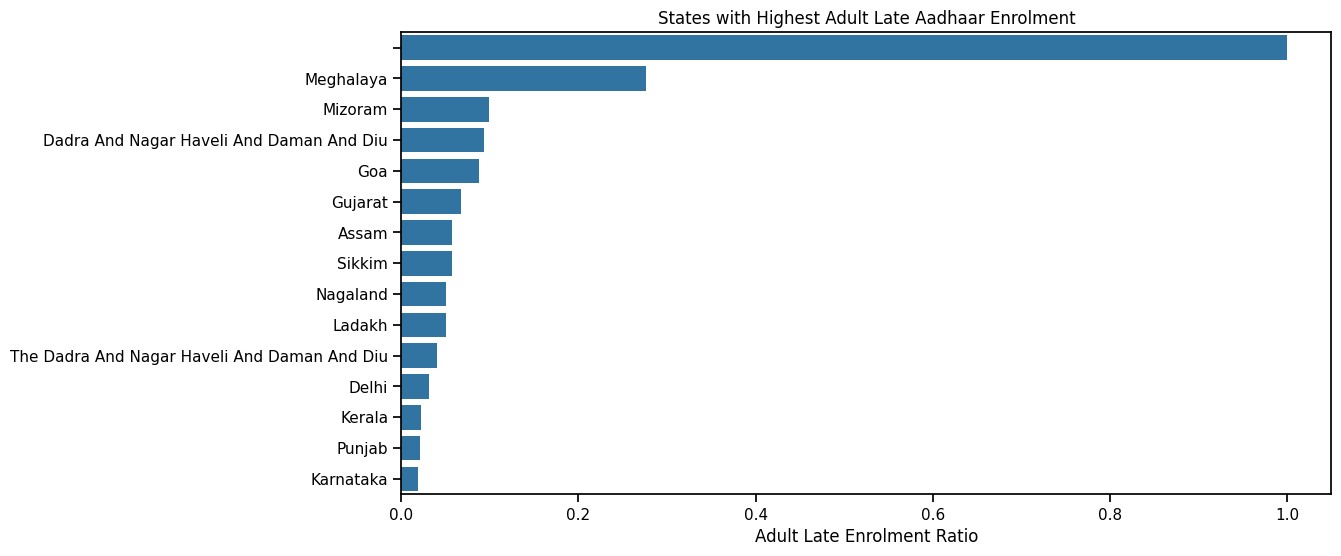

In [9]:
# Visualizing states with highest adult late enrolment ratios
plt.figure(figsize=(12,6))
sns.barplot(
    data=state_summary.reset_index().head(15),
    x='avg_adult_late_ratio',
    y='state_clean'
)
plt.title("States with Highest Adult Late Aadhaar Enrolment")
plt.xlabel("Adult Late Enrolment Ratio")
plt.ylabel("")
plt.show()


District-Level Daily Enrolment Volatility/Enrolment Volatility as a Migration & Stress Signal

In [10]:
# Compute daily enrolments at district level
district_daily = (
    df.groupby(['state_clean', 'district', 'date'])
      ['total_enrolments']
      .sum()
      .reset_index()
)

# Measure volatility as standard deviation of daily enrolments
district_volatility = (
    district_daily
    .groupby(['state_clean', 'district'])
    ['total_enrolments']
    .std()
    .reset_index(name='daily_volatility')
    .sort_values('daily_volatility', ascending=False)
)

district_volatility.head()


,state_clean,district,daily_volatility
381,Karnataka,Bengaluru Urban,6297.419604
942,West Bengal,Dinajpur Uttar,4556.581650
148,Bihar,Purbi Champaran,4190.923874
145,Bihar,Pashchim Champaran,3820.298530
929,West Bengal,24 Paraganas North,2861.661143


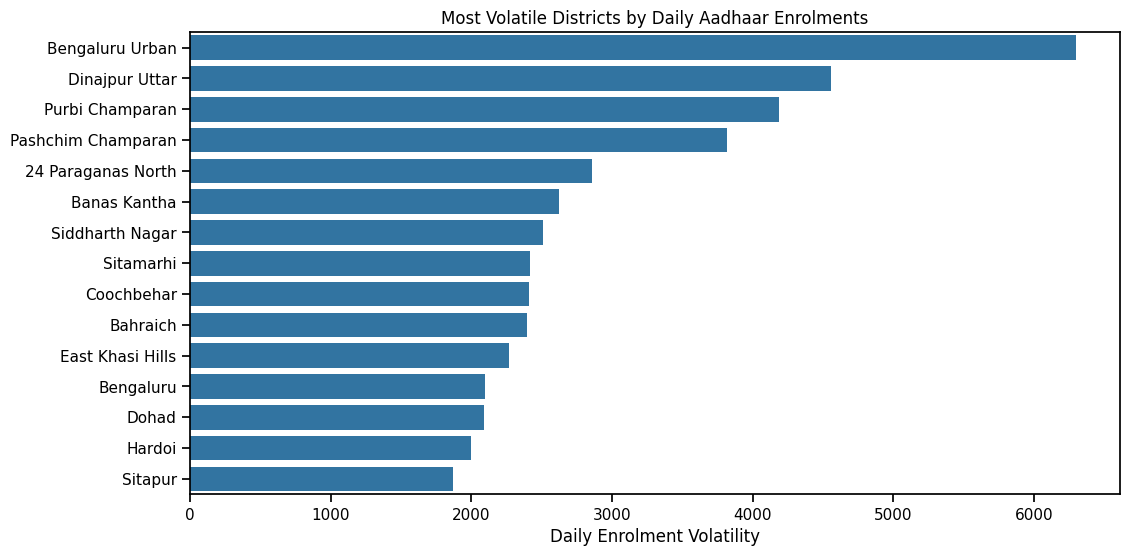

In [11]:
# Plot districts with highest enrolment volatility
plt.figure(figsize=(12,6))
sns.barplot(
    data=district_volatility.head(15),
    x='daily_volatility',
    y='district'
)
plt.title("Most Volatile Districts by Daily Aadhaar Enrolments")
plt.xlabel("Daily Enrolment Volatility")
plt.ylabel("")
plt.show()


Pincode-Level Concentration within Districts/Aadhaar Enrolment is Spatially Concentrated Within Districts

In [12]:
# Aggregate enrolments at pincode level
pincode_summary = (
    df.groupby(['state_clean', 'district', 'pincode'])
      ['total_enrolments']
      .sum()
      .reset_index()
)

# Total enrolments per district
district_totals = (
    pincode_summary
    .groupby(['state_clean', 'district'])
    ['total_enrolments']
    .sum()
    .reset_index(name='district_total')
)

# Merge to compute share contribution
pincode_summary = pincode_summary.merge(
    district_totals,
    on=['state_clean', 'district']
)

# Share of enrolment contributed by each pincode
pincode_summary['share'] = (
    pincode_summary['total_enrolments'] /
    pincode_summary['district_total']
)

pincode_summary.sort_values('share', ascending=False).head(10)



,state_clean,district,pincode,total_enrolments,district_total,share
25692,West Bengal,West Medinipur,721201.0,1.0,1.0,1.0
0,,100000,100000.0,4.0,4.0,1.0
9505,Karnataka,Ramanagara,562160.0,204.0,204.0,1.0
17456,Sikkim,North,737116.0,2.0,2.0,1.0
4728,Chhattisgarh,Mohalla-Manpur-Ambagarh Chowki,491229.0,2.0,2.0,1.0
16955,Rajasthan,Jalore,343001.0,490.0,490.0,1.0
4870,Daman Diu,Daman,396210.0,3.0,3.0,1.0
4871,Daman Diu,Diu,362570.0,1.0,1.0,1.0
24665,West Bengal,MALDA,742202.0,3.0,3.0,1.0
4739,Chhattisgarh,Narayanpur,494661.0,162.0,162.0,1.0


In [13]:
top_pincode_share = (
    pincode_summary
    .groupby(['state_clean','district'])
    .apply(lambda x: x.nlargest(int(len(x)*0.1), 'share')['share'].sum())
    .reset_index(name='top_10pct_pincode_share')
)

top_pincode_share.sort_values('top_10pct_pincode_share', ascending=False).head(10)


/tmp/ipython-input-1723279877.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(int(len(x)*0.1), 'share')['share'].sum())


,state_clean,district,top_10pct_pincode_share
953,West Bengal,Kalimpong,0.944079
667,Punjab,Kapurthala,0.931574
890,Uttar Pradesh,Moradabad,0.915511
760,Tamil Nadu,Thiruvallur,0.908136
542,Maharashtra,Raigad,0.907609
288,Haryana,Panipat,0.907360
864,Uttar Pradesh,Hapur,0.906847
857,Uttar Pradesh,Firozabad,0.890533
268,Gujarat,Valsad,0.881895
668,Punjab,Ludhiana,0.875046


Time-Series Shock Analysis (Example State)

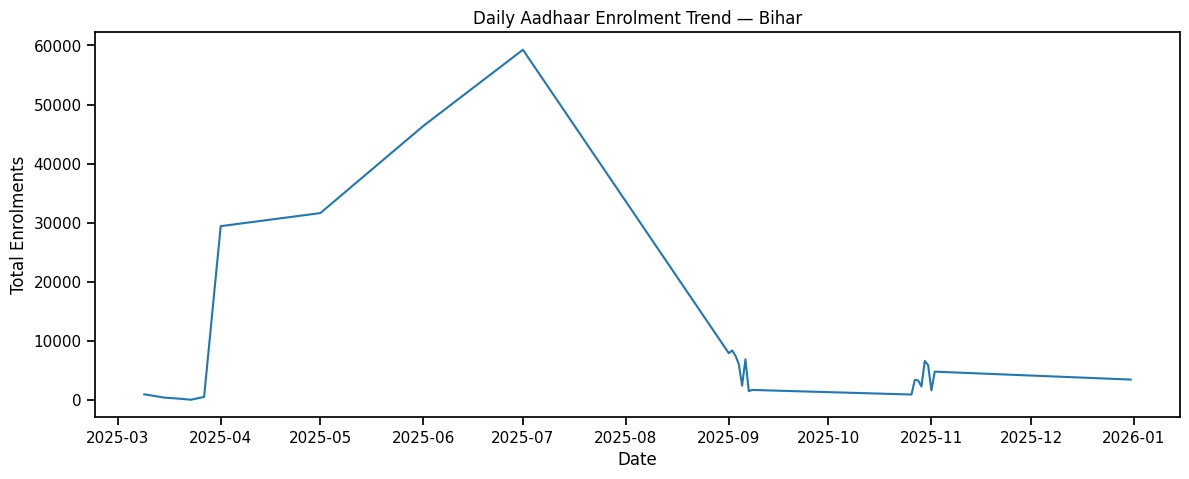

In [14]:
# Aggregate daily enrolments at state level
state_daily = (
    df.groupby(['state_clean', 'date'])
      ['total_enrolments']
      .sum()
      .reset_index()
)

# Example state for detailed temporal analysis
example_state = "Bihar"

plt.figure(figsize=(14,5))
sns.lineplot(
    data=state_daily[state_daily['state_clean'] == example_state],
    x='date',
    y='total_enrolments'
)
plt.title(f"Daily Aadhaar Enrolment Trend — {example_state}")
plt.xlabel("Date")
plt.ylabel("Total Enrolments")
plt.show()
